# Analyzing the results of regular Logistic Regression CV against the "gaussian-mixture perturbation" synthetic datasets

## I. Unpack results.

In [1]:
%pylab inline
import pickle
import pandas as pd
from matplotlib_venn import venn3, venn3_circles, venn2
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

repo_path = '/Users/alex/Documents/gslr/'
KEGG_path = repo_path + 'experiments/KEGG/KEGG_df.filtered.with_correlates.pickle'

# File was serialized like so: 
#   results = {pathway_id: (scores, features) for (pathway_id, scores, features) in results}
#   pickle.dump(results, open('results.pickle', 'wb'))

results = pickle.load(open('logit_gmm_results.pickle', 'rb'))

Populating the interactive namespace from numpy and matplotlib


In [2]:
scores = pd.DataFrame({pathway_id: scores[0].flatten().tolist() for pathway_id, scores, chosen_genes in results})
features = {pathway: features for pathway, scores, features in results}

## II. Analyze test-accuracy across folds (k = 10)

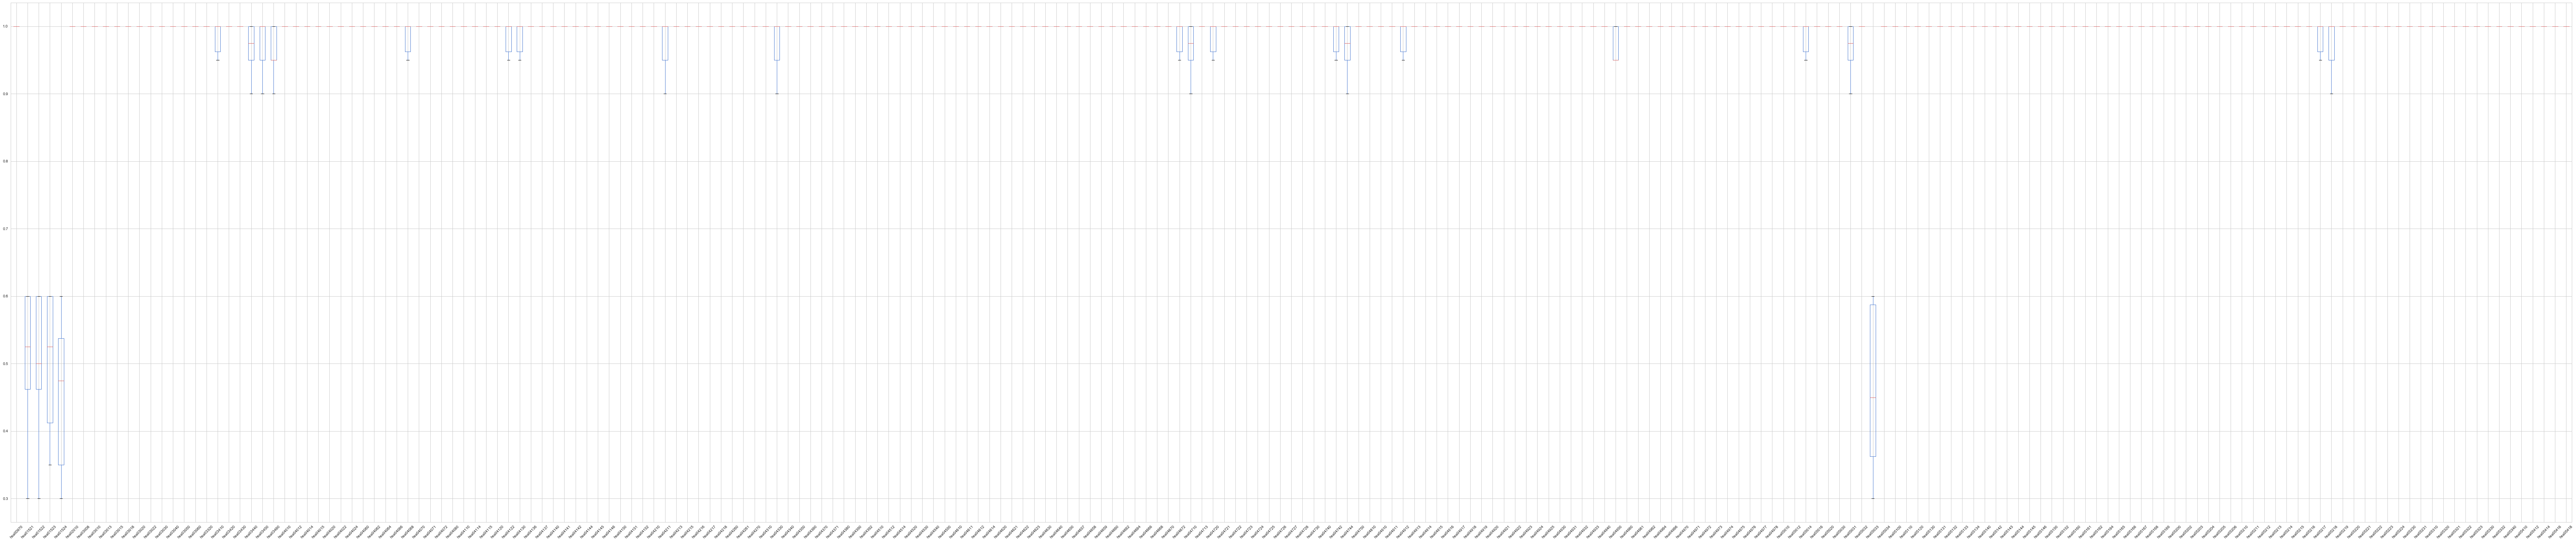

In [3]:
scores.plot.box(figsize=(120,25), rot=45)#.get_figure().savefig("/Users/alex/Desktop/logit_results.png")

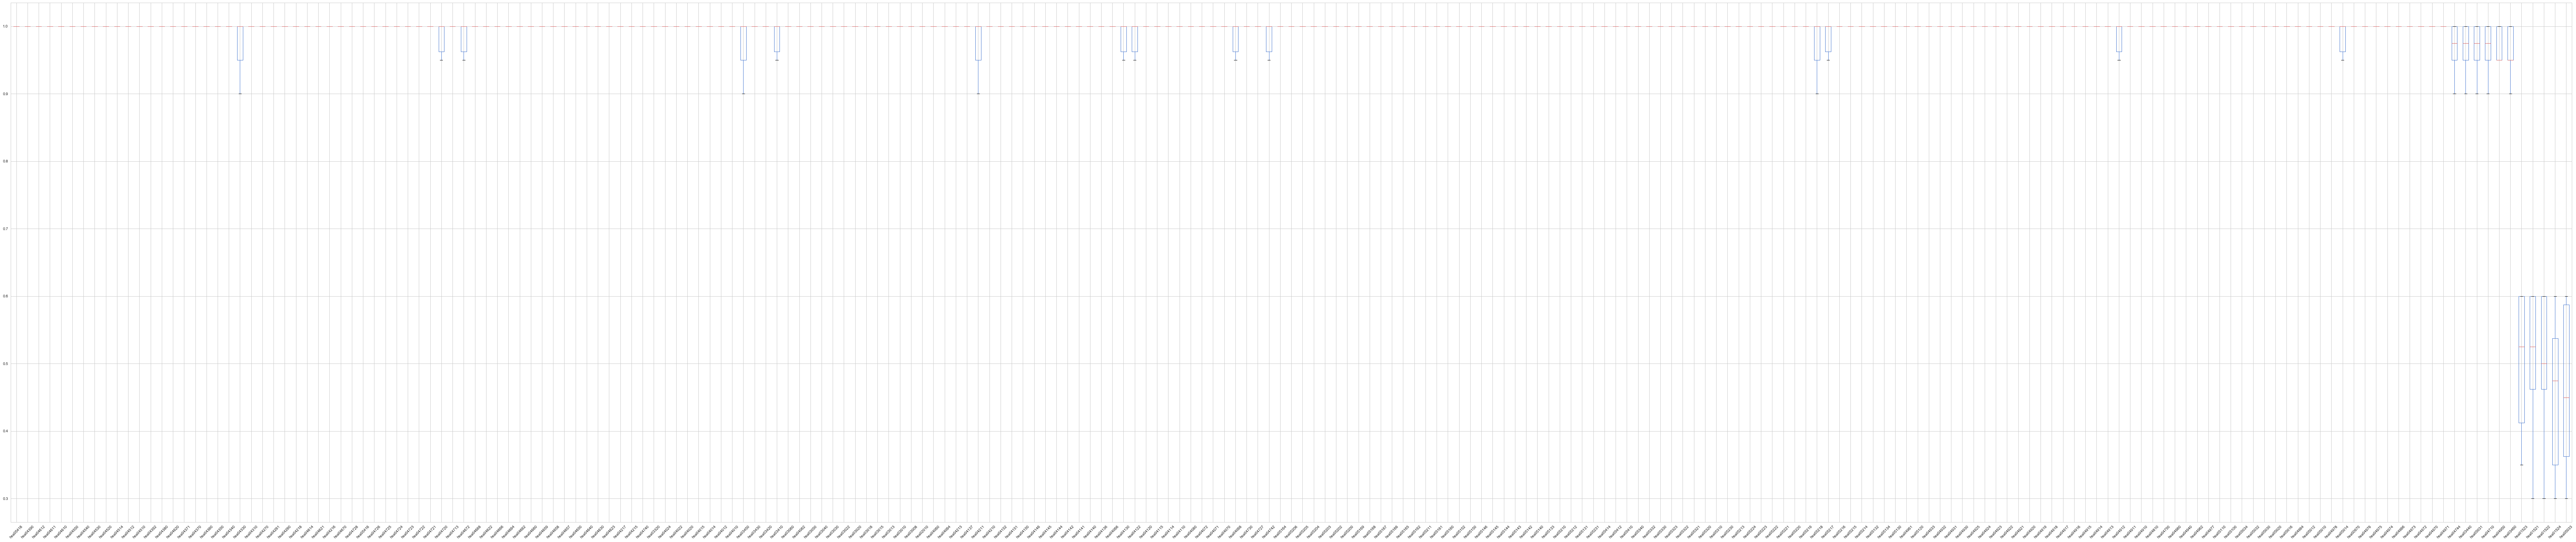

In [4]:
scores[scores.median().sort_values(ascending=False).index].plot.box(figsize=(120,25), rot=45)#.get_figure().savefig("/Users/alex/Desktop/logit_results_sorted.png")

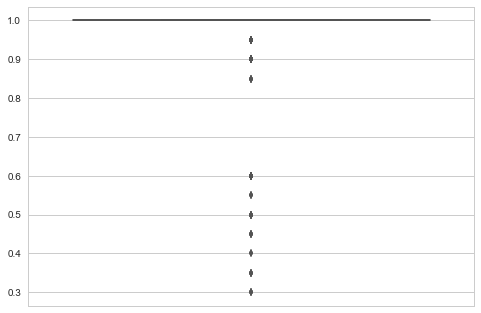

In [5]:
sns.boxplot(y=pd.melt(scores)['value'].tolist())

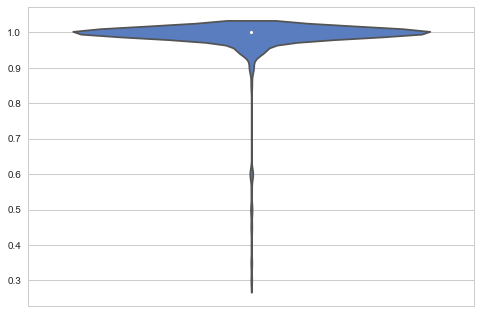

In [6]:
sns.violinplot(y=pd.melt(scores)['value'].tolist())
# sns.swarmplot(y=pd.melt(scores)['value'].tolist(), color="white", edgecolor="gray")

In [7]:
means = scores.mean()
np.mean(means.values), np.std(means.values)

(0.98390829694323145, 0.074619180900321921)

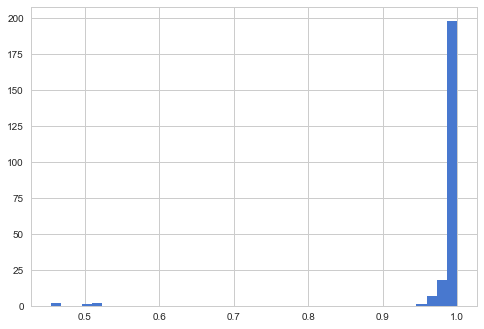

In [8]:
means.hist(bins=40)

## III. Analyze pathway recovery

In [9]:
pathways_df = pd.read_pickle(KEGG_path)

pathways = {pathway_id: pathways_df.loc[pd.IndexSlice[:, :, [pathway_id]],['genes', 'correlates']].values[0][0] for pathway_id in pathways_df.index.get_level_values(2)}

In [10]:
set(pathways.keys()) == set(features.keys())

True

In [11]:
features = {key: (set(pathways[key]), set(features[key])) for key in (set(pathways.keys()) & set(features.keys()))}

In [12]:
pair = list(features.items())[0][1]


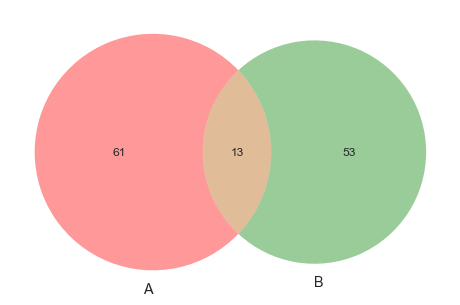

In [13]:
venn2([pair[0], pair[1]])

In [14]:
def recall(truth, pred):    
    return len(truth & pred) / float(len(truth))
    
def precision(truth, pred):
    return len(truth & pred) / float(len(pred))


### Turns out 9 of the pathways have no true genes. See below:

In [15]:
{pathway: (len(truth), len(pred)) for pathway, (truth, pred) in features.items()}

{'hsa00970': (66, 78),
 'hsa01521': (0, 134),
 'hsa01522': (0, 170),
 'hsa01523': (0, 151),
 'hsa01524': (0, 145),
 'hsa02010': (44, 77),
 'hsa03008': (101, 41),
 'hsa03010': (153, 59),
 'hsa03013': (171, 56),
 'hsa03015': (91, 72),
 'hsa03018': (78, 54),
 'hsa03020': (31, 77),
 'hsa03022': (45, 68),
 'hsa03030': (36, 36),
 'hsa03040': (134, 63),
 'hsa03050': (45, 39),
 'hsa03060': (23, 50),
 'hsa03320': (72, 32),
 'hsa03410': (33, 78),
 'hsa03420': (47, 60),
 'hsa03430': (23, 69),
 'hsa03440': (41, 85),
 'hsa03450': (13, 92),
 'hsa03460': (54, 57),
 'hsa04010': (255, 59),
 'hsa04012': (86, 56),
 'hsa04014': (227, 58),
 'hsa04015': (210, 51),
 'hsa04020': (182, 52),
 'hsa04022': (163, 51),
 'hsa04024': (198, 66),
 'hsa04060': (270, 60),
 'hsa04062': (185, 60),
 'hsa04064': (95, 74),
 'hsa04066': (99, 55),
 'hsa04068': (131, 63),
 'hsa04070': (99, 79),
 'hsa04071': (118, 51),
 'hsa04072': (146, 67),
 'hsa04080': (277, 44),
 'hsa04110': (124, 54),
 'hsa04114': (124, 56),
 'hsa04115': (68

In [16]:
summary = {pathway: (recall(truth, pred), precision(truth, pred)) for pathway, (truth, pred) in features.items()  if len(truth) > 0}
summary = pd.DataFrame(summary, index=['recall', 'precision'])
summary

,hsa00970,hsa02010,hsa03008,hsa03010,hsa03013,hsa03015,hsa03018,hsa03020,hsa03022,hsa03030,...,hsa05322,hsa05323,hsa05330,hsa05332,hsa05340,hsa05410,hsa05412,hsa05414,hsa05416,hsa05418
recall,0.30303,0.227273,0.108911,0.104575,0.093567,0.186813,0.141026,0.451613,0.355556,0.25,...,0.037594,0.166667,0.184211,0.146341,0.189189,0.120482,0.138889,0.188889,0.152542,0.043165
precision,0.25641,0.129870,0.268293,0.271186,0.285714,0.236111,0.203704,0.181818,0.235294,0.25,...,0.227273,0.312500,0.233333,0.193548,0.184211,0.250000,0.222222,0.369565,0.236842,0.250000


In [17]:
summary.mean(axis=1)

recall       0.156616
precision    0.230572
dtype: float64

In [18]:
summary.std(axis=1)

recall       0.111225
precision    0.081565
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117016d68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1170757f0>]], dtype=object)

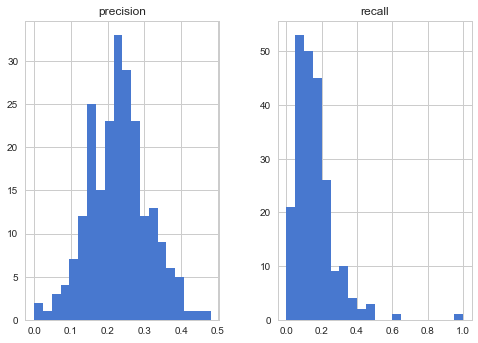

In [19]:
summary.transpose().hist(bins=20)